# DESI Imaging Validation 


## Introduction

This is the User Notebook to run validation tests at NERSC
You only need to input your localdir (at NERSC) to save outputs.

Each cell should have one test <br>
To run a test you need to input<br>
*    survey: DECaLS/BASS/MZLS  
*    release: DR3/DR4 
*    bands: g,r,z
*    localdir: yourdirectory 
*    verbose: true/false 
<br>

Output: path to png image to plot 

## Enter your directory for outputs

In [2]:
from desi_image_validation import *
from IPython.display import Image

In [3]:
localdir = '/global/homes/m/manera/DESI/validation-outputs/'

# Validation Tests 

### Sanity check to see the hardcoded values of a sample

In [4]:
verbose=False
sample=mysample('DECaLS','DR5','g',localdir,verbose)

# TEST Information 
print '----- check values sample ----'
print 'band = ', sample.band
print 'localdir = ', sample.localdir
print 'survey = ', sample.survey
print 'DR = ', sample.DR
print 'path ccd = ',sample.ccds
print '----------'
print 'zp0 = ', sample.zp0
print 'extinction coef = ', sample.extc
print 'extinction raw = ', sample.be
print 'magnitude limit = ', sample.recm
print 'photoz req = ', sample.phreq
print 'catalogue = ', sample.catalog
print  'verbose = ', sample.verbose
print 'fraction of exposures = ', sample.FracExp
print '------------------------'
print '                        '

----- check values sample ----
band =  g
localdir =  /global/homes/m/manera/DESI/validation-outputs/
survey =  DECaLS
DR =  DR5
path ccd =  /global/project/projectdirs/cosmo/data/legacysurvey/dr5/ccds-annotated-dr5.fits.gz
----------
zp0 =  25.08
extinction coef =  3.303
extinction raw =  1
magnitude limit =  24.0
photoz req =  0.01
catalogue =  DECaLS_DR5
verbose =  False
fraction of exposures =  [0.02, 0.24, 0.5, 0.22, 0.02]
------------------------
                        


### Extinction corrected depth maps (Val 3.4c)

Visually explore the maps for depth patterns

> Projection ivar  total  took : 28.13 sec for 1032960 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_ivar__total.fits
Area is  3386.54985843  sq. deg.
6391 of  1032960  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.492640974  and max  depth  =  25.2674991197
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_BASS_DR41024.png


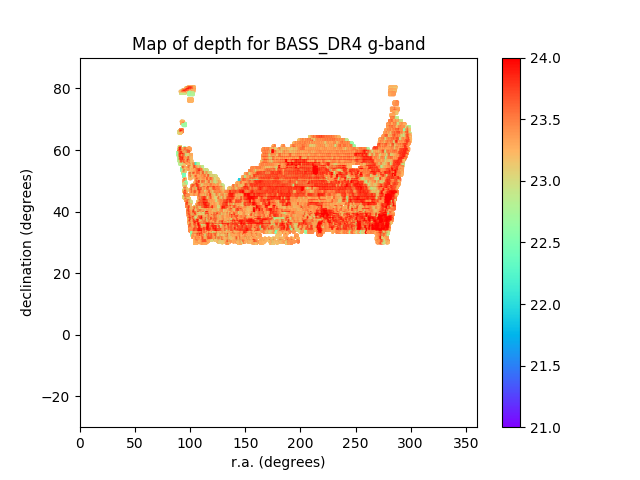

In [4]:
verbose=False
sample=mysample('BASS','DR4','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 24.13 sec for 900041 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_r_nside1024_oversamp1_ivar__total.fits
Area is  2950.77613957  sq. deg.
3553 of  900041  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0032415064  and max  depth  =  24.093121473
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_BASS_DR41024.png


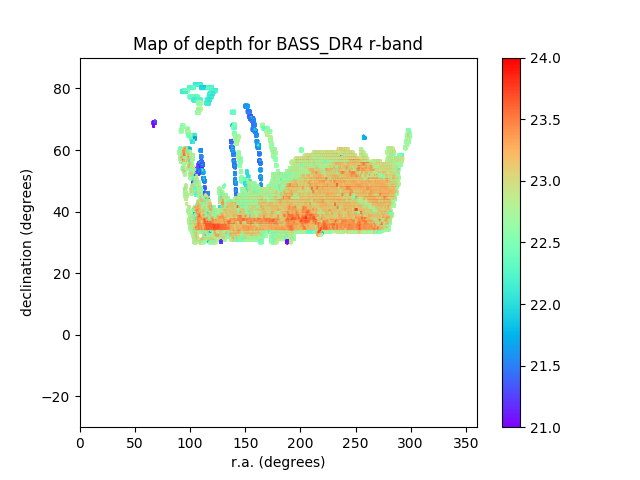

In [5]:
verbose=False
sample=mysample('BASS','DR4','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 28.03 sec for 1003899 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR4/nside1024_oversamp1/MZLS_DR4_band_z_nside1024_oversamp1_ivar__total.fits
Area is  3363.76762585  sq. deg.
6788 of  1026011  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0101700532  and max  depth  =  23.5305051132
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_MZLS_DR41024.png


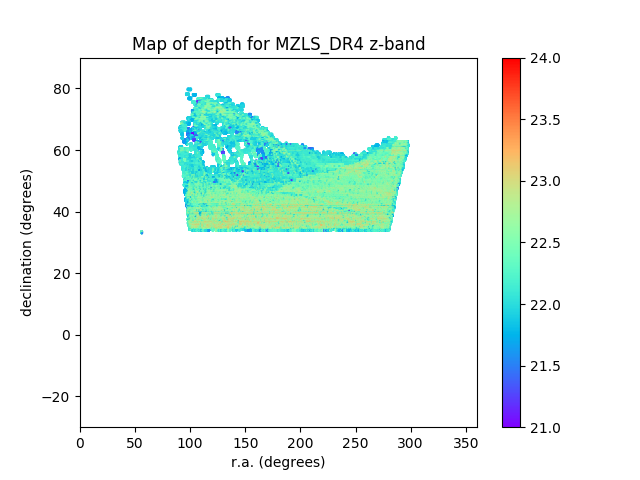

In [6]:
verbose=False
sample=mysample('MZLS','DR4','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

desi_image_validation.py:191: RuntimeWarning: divide by zero encountered in divide
  ivar= 1./nmag**2.


> Projection ivar  total  took : 53.07 sec for 2141507 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_g_nside1024_oversamp1_ivar__total.fits
Area is  7020.91100108  sq. deg.
157 of  2141507  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.2726973822  and max  depth  =  27.5441621361
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_g_DECaLS_DR51024.png


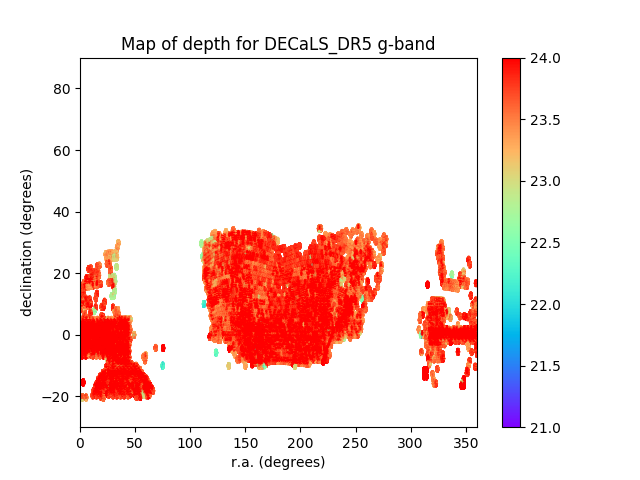

In [5]:
verbose=False
sample=mysample('DECaLS','DR5','g',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

desi_image_validation.py:191: RuntimeWarning: divide by zero encountered in divide
  ivar= 1./nmag**2.


> Projection ivar  total  took : 48.66 sec for 2272139 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_r_nside1024_oversamp1_ivar__total.fits
Area is  7449.18681147  sq. deg.
3402 of  2272139  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.0003041849  and max  depth  =  26.7596550836
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_r_DECaLS_DR51024.png


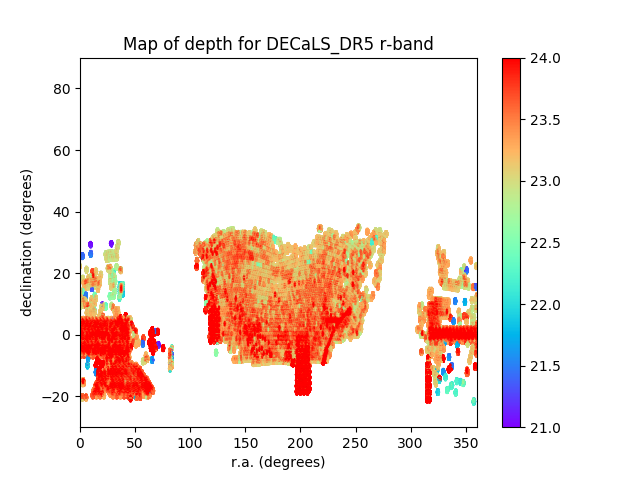

In [5]:
verbose=False
sample=mysample('DECaLS','DR5','r',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

> Projection ivar  total  took : 65.21 sec for 3012542 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR5/nside1024_oversamp1/DECaLS_DR5_band_z_nside1024_oversamp1_ivar__total.fits
Area is  9876.59123645  sq. deg.
5771 of  3012542  pixels are not plotted as their  depth  <  21.0
Within the plot, min  depth =  21.000382906  and max  depth  =  26.373551906
saving plot to  /global/homes/m/manera/DESI/validation-outputs/depth_z_DECaLS_DR51024.png


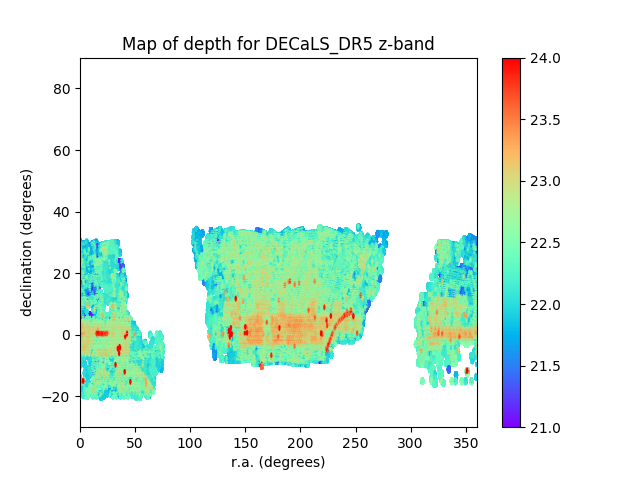

In [6]:
verbose=False
sample=mysample('DECaLS','DR5','z',localdir,verbose)
fname=val3p4c_depthfromIvar(sample)
fig = Image(filename=(fname))
fig

### Depth Histograms (Val 3.4)

Requirement V3.4<br>
90% filled to g=24, r=23.4 and z=22.5 and 95% and 98% at 0.3/0.6 mag shallower.<br>
Done by montecarlo exposure statistics to the final ratio of exposures

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  528626
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  24.2045961667 ; Median =  24.2295882162 ; Std =  0.273799394377
percentage better than requirements = 0.81069
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.8734329669 23.7393995512 23.5507659755
min,max depth =  20.334274292 25.3447789117
counts below  21.0  =  2
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5g_pred_exposures.png


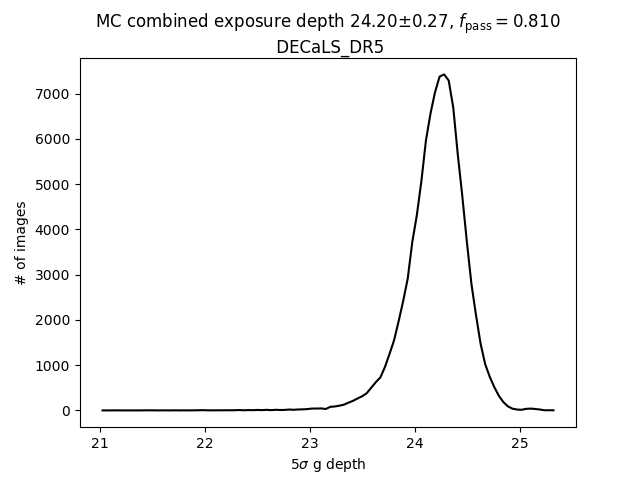

In [3]:
verbose=True
sample=mysample('DECaLS','DR5','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  539702
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.8406640874 ; Median =  23.8168901621 ; Std =  0.355606292003
percentage better than requirements = 0.9172
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.4368556732 23.3017984264 23.1253031158
min,max depth =  20.5585918427 25.147056462
counts below  21.0  =  2
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5r_pred_exposures.png


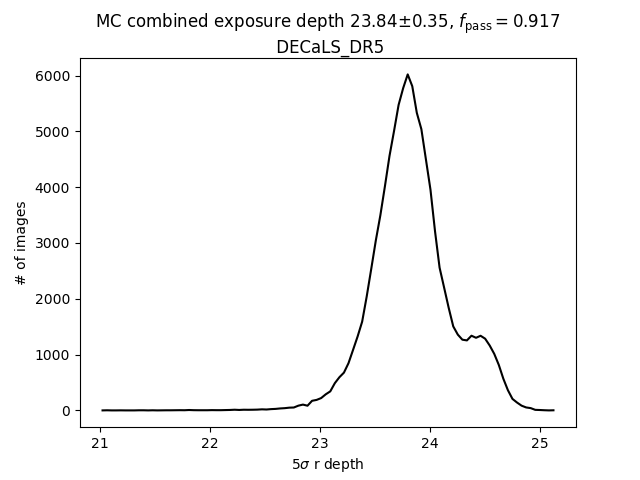

In [4]:
verbose=True
sample=mysample('DECaLS','DR5','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  2723220
Counts before or during 2014 =  1266922
Counts with dec < -20 =  13075
Number of objects in the sample =  689388
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  22.8073399713 ; Median =  22.8134102515 ; Std =  0.309430325915
percentage better than requirements = 0.8696
Requirements are > 90%, 95% and 98% at 22.5, 22.3, 21
Results are:  22.4511835453 22.3238838115 22.159117316
min,max depth =  -0.0385327376425 23.8207055196
counts below  21.0  =  18
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/DECaLS_DR5z_pred_exposures.png


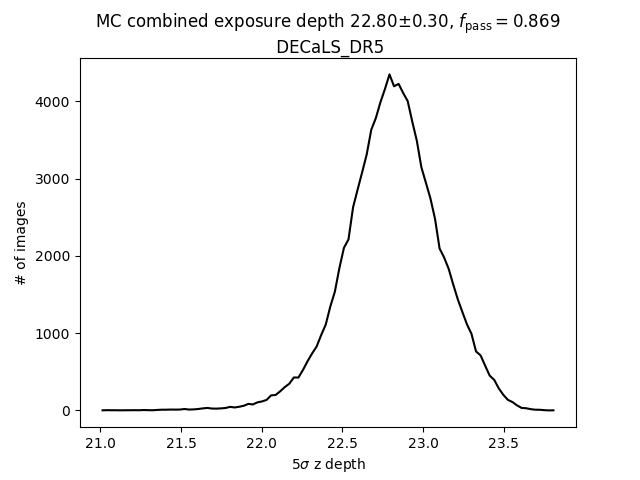

In [5]:
verbose=True
sample=mysample('DECaLS','DR5','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  49032
Counts before or during 2014 =  0
Counts with dec < -20 =  16
Number of objects in the sample =  21919
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.9078045632 ; Median =  23.916499922 ; Std =  0.157173139042
percentage better than requirements = 0.22469
Requirements are > 90%, 95% and 98% at 24, 23.7, 23.4
Results are:  23.7394484346 23.6691735204 23.5798986111
min,max depth =  4.4408920985e-15 24.4988843412
counts below  21.0  =  1
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR4g_pred_exposures.png


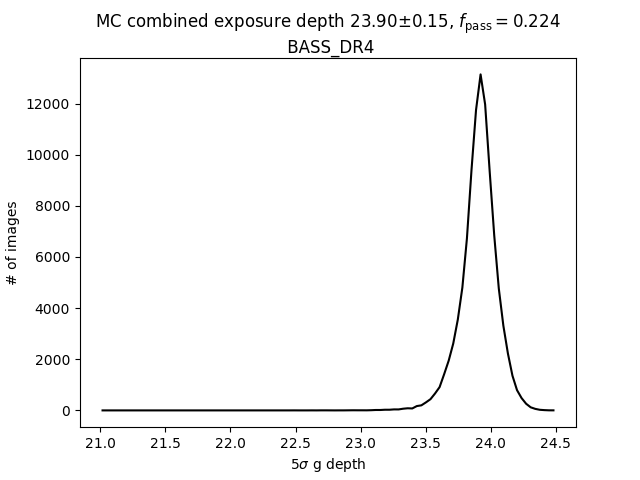

In [3]:
verbose=True
sample=mysample('BASS','DR4','g',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  49032
Counts before or during 2014 =  0
Counts with dec < -20 =  16
Number of objects in the sample =  23718
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  23.3125535232 ; Median =  23.3314726417 ; Std =  0.242451537445
percentage better than requirements = 0.28556
Requirements are > 90%, 95% and 98% at 23.4, 23.1, 22.8
Results are:  23.1149276268 23.0344432049 22.915762313
min,max depth =  4.4408920985e-15 23.9711193767
counts below  21.0  =  7
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/BASS_DR4r_pred_exposures.png


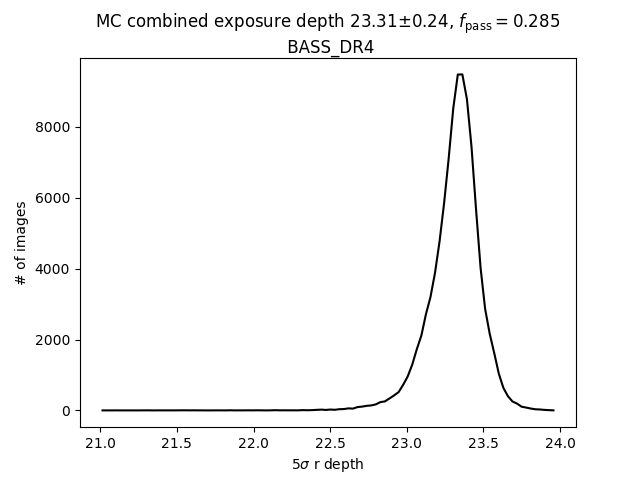

In [4]:
verbose=True
sample=mysample('BASS','DR4','r',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

-----------
Number of objects =  80486
Counts before or during 2014 =  0
Counts with dec < -20 =  0
Number of objects in the sample =  72150
Total images drawn with either 1,2,3,4,5 exposures 100000
Mean =  22.8105140816 ; Median =  22.8344044032 ; Std =  0.2607307769
percentage better than requirements = 0.96722
Requirements are > 90%, 95% and 98% at 22.5, 22.3, 21
Results are:  22.6225030872 22.5438015882 22.4455493114
min,max depth =  4.4408920985e-15 23.2442334432
counts below  21.0  =  9
saving histogram plot in /global/homes/m/manera/DESI/validation-outputs/validationplots/MZLS_DR4z_pred_exposures.png


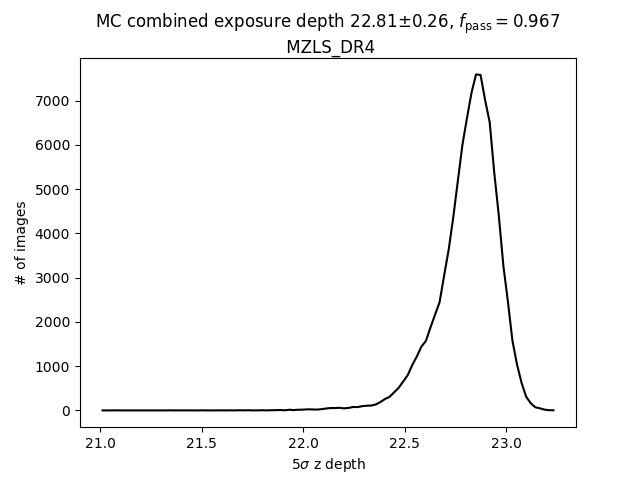

In [5]:
verbose=True
sample=mysample('MZLS','DR4','z',localdir,verbose)
fname=val3p4b_maghist_pred(sample)
fig = Image(filename=(fname))
fig

### Seeing Requirements (Val 4.1)

z-band image quality will be smaller than 1.3 arcsec FWHM in at least one pass.<br>

val3p4c_seeing        - runs everything <br>
val3p4c_seeingplots   - runs the plots only if the previous have been run

> Projection FWHM  min  took : 23.44 sec for 1032960 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_FWHM__min.fits
> Projection FWHM  num  took : 20.59 sec for 1032960 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_FWHM__num.fits
2.37794 9.52291
1.0 38.0
1032960 131050
2.37794 7.25379
saving plot to  /global/homes/m/manera/DESI/validation-outputs/FWHMminpass3_g_BASS_DR41024map.png
The total area is  3386.54985843  sq. deg.
A total of  429.64621955 squaredegrees with pass >= 3
#FWHM  Area(>FWHM) Fractional Area(>FWHM)
1.29369443974 3.70141611501 0.00863037678589
#mean  STD
3.31503719954 0.451763193891
Area with FWHM greater than 1.3 arcsec fraction
3.70 0.01
saving plot to  /global/homes/m/manera/DESI/validation-outputs/FWHMminpass3_g_BASS_DR41024histo.png
For pass >=3


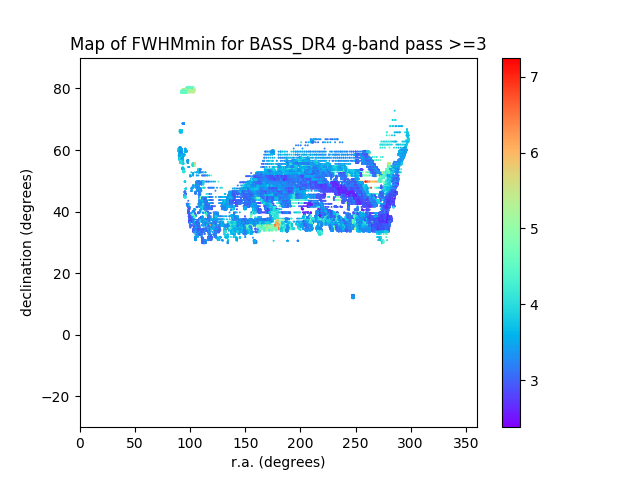

In [3]:
verbose=True
sample= mysample('BASS','DR4','g',localdir,verbose)
#fname1,fname2 = val3p4c_seeing(sample)
fname1, fname2 = val3p4c_seeing(sample)
print 'For pass >=3'
fig = Image(filename=(fname1))
fig

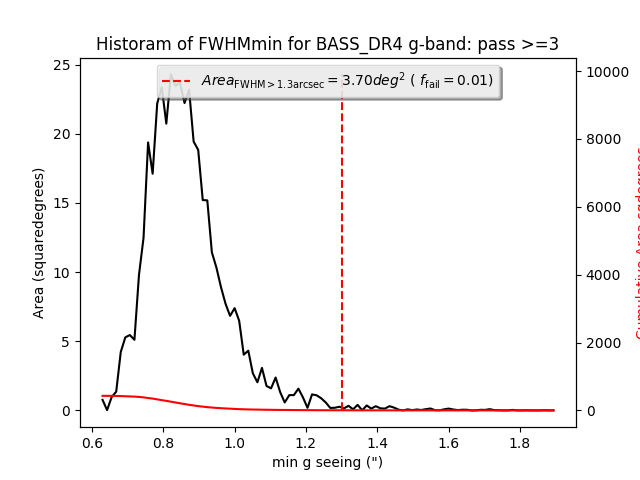

In [4]:
fig = Image(filename=(fname2))
fig

### Photometric Requirements (Val 5.1e)

Requirement V5.1<br>
No region > 3deg will be based upon non-photometric observations<br>
Done by visual inspection and if necessary pixel value counts.<br>

> Projection zptvar  min  took : 20.32 sec for 1040981 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_zptvar__min.fits
Plotting min zpt rms
Min and Max values of  min-zpt-rms-flux  values is  0.000341442358971 0.010842128031
Number of pixels is  1040981
Area is  3412.84663315  sq. deg.
Number of udegrade pixels with  photometric-pixels  >  0.01  for all subpixels = 0
nside of udgraded pixels is :  64


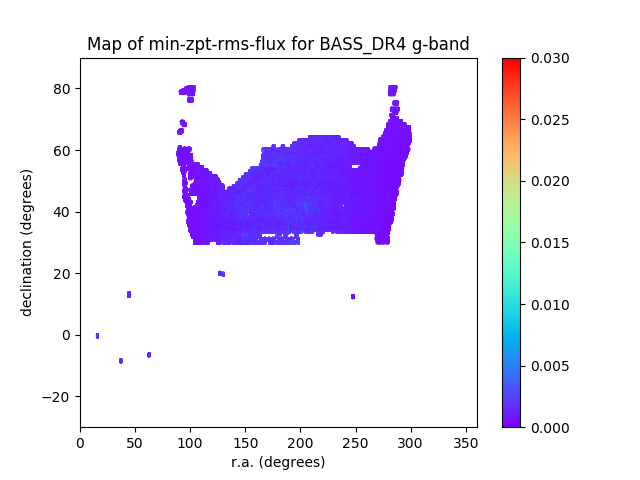

In [7]:
verbose=False
sample = mysample('BASS','DR4','g',localdir,verbose)
fname = v5p1e_photometricReqPlot(sample)
fig = Image(filename=(fname))
fig

desi_image_validation.py:447: RuntimeWarning: divide by zero encountered in divide
  zptvar = tbdata['CCDPHRMS']**2/tbdata['CCDNMATCH']


> Projection zptvar  min  took : 17.61 sec for 908419 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_r_nside1024_oversamp1_zptvar__min.fits
Plotting min zpt rms
Min and Max values of  min-zpt-rms-flux  values is  0.000370434955345 0.00748266271781
Number of pixels is  908419
Area is  2978.2433355  sq. deg.
Number of udegrade pixels with  photometric-pixels  >  0.01  for all subpixels = 0
nside of udgraded pixels is :  64


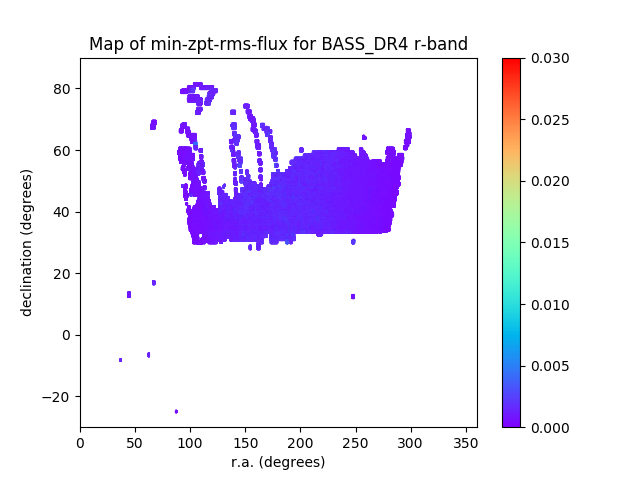

In [6]:
verbose=False
sample = mysample('BASS','DR4','r',localdir,verbose)
fname = v5p1e_photometricReqPlot(sample)
fig = Image(filename=(fname))
fig

desi_image_validation.py:454: RuntimeWarning: divide by zero encountered in divide
  zptvar = tbdata['CCDPHRMS']**2/tbdata['CCDNMATCH']


> Projection zptvar  min  took : 94.96 sec for 1014477 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR4/nside1024_oversamp1/MZLS_DR4_band_z_nside1024_oversamp1_zptvar__min.fits
Plotting min zpt rms
Min and Max values of  min-zpt-rms-flux  values is  0.00073402407614 0.0432843339667
Number of pixels is  1014477
Area is  3325.95351294  sq. deg.
Number of udegrade pixels with  photometric-pixels  >  0.02  for all subpixels = 0
nside of udgraded pixels is :  64


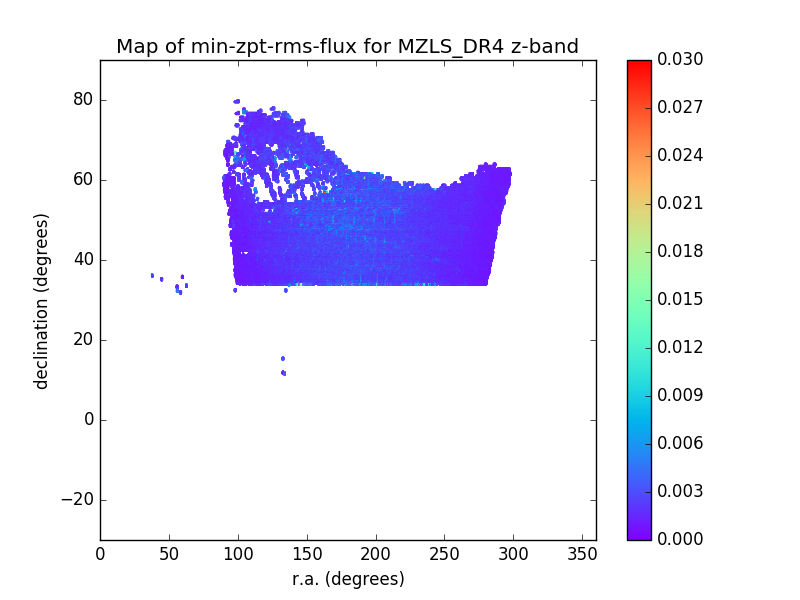

In [3]:
verbose=False
sample = mysample('MZLS','DR4','z',localdir,verbose)
fname = v5p1e_photometricReqPlot(sample)
fig = Image(filename=(fname))
fig

### Area Requirements (Val 5.3 and Val 3.1)

Requirement V5.1<br>
450 sq degrees overlap between all instruments br>
Requirement V3.1<br> 
1200 sq degrees filled <br> 

> Projection nccd1  total  took : 16.34 sec for 896872 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR3/nside1024_oversamp1/DECaLS_DR3_band_g_nside1024_oversamp1_nccd1__total.fits
> Projection nccd2  total  took : 18.89 sec for 1040981 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_g_nside1024_oversamp1_nccd2__total.fits
Area of sample DECaLS_DR3  is  2940.0  sq. deg.
Area of sample BASS_DR4  is  3413.0  sq. deg.
The total JOINT area is  6324.0 sq. deg.
The INTERSECTING area is  29.0  sq. deg.


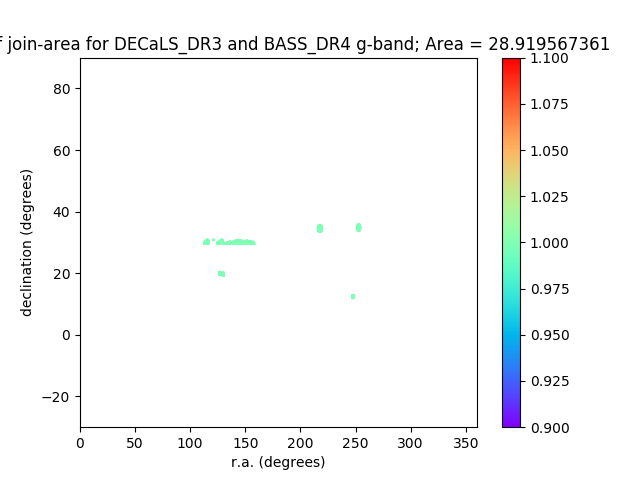

In [4]:
verbose=False
sample1 = mysample('DECaLS','DR3','g',localdir,verbose)
sample2 = mysample('BASS','DR4','g',localdir,verbose)
fname = v3p5_Areas(sample1,sample2)
fig = Image(filename=(fname))
fig

> Projection nccd1  total  took : 16.55 sec for 929020 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR3/nside1024_oversamp1/DECaLS_DR3_band_r_nside1024_oversamp1_nccd1__total.fits
> Projection nccd2  total  took : 17.57 sec for 908419 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//BASS_DR4/nside1024_oversamp1/BASS_DR4_band_r_nside1024_oversamp1_nccd2__total.fits
Area of sample DECaLS_DR3  is  3046.0  sq. deg.
Area of sample BASS_DR4  is  2978.0  sq. deg.
The total JOINT area is  6008.0 sq. deg.
The INTERSECTING area is  16.0  sq. deg.


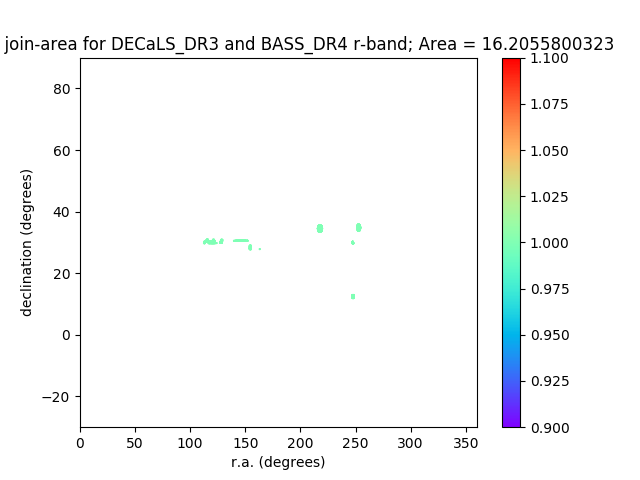

In [5]:
verbose=False
sample1 = mysample('DECaLS','DR3','r',localdir,verbose)
sample2 = mysample('BASS','DR4','r',localdir,verbose)
fname = v3p5_Areas(sample1,sample2)
fig = Image(filename=(fname))
fig

> Projection nccd1  total  took : 38.14 sec for 2086258 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//DECaLS_DR3/nside1024_oversamp1/DECaLS_DR3_band_z_nside1024_oversamp1_nccd1__total.fits
> Projection nccd2  total  took : 18.47 sec for 1014477 pixels
Creating and writing /global/homes/m/manera/DESI/validation-outputs//MZLS_DR4/nside1024_oversamp1/MZLS_DR4_band_z_nside1024_oversamp1_nccd2__total.fits
Area of sample DECaLS_DR3  is  6840.0  sq. deg.
Area of sample MZLS_DR4  is  3326.0  sq. deg.
The total JOINT area is  10138.0 sq. deg.
The INTERSECTING area is  28.0  sq. deg.


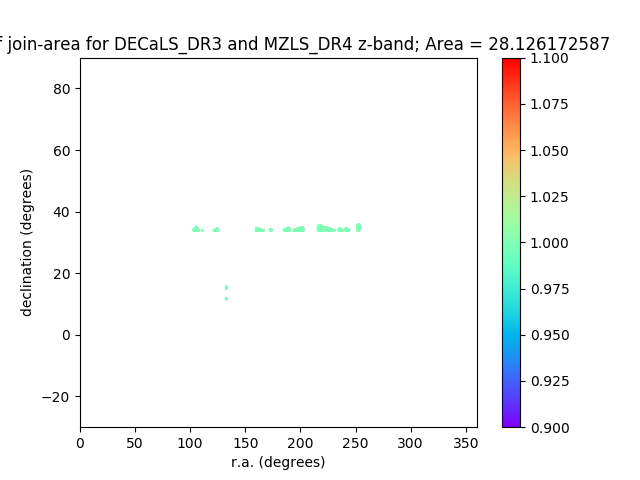

In [3]:
verbose=False
sample1 = mysample('DECaLS','DR3','z',localdir,verbose)
sample2 = mysample('MZLS','DR4','z',localdir,verbose)
fname = v3p5_Areas(sample1,sample2)
fig = Image(filename=(fname))
fig

###  OLD TEST  Read Header and files

In [1]:
import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
from multiprocessing import Pool
import matplotlib as mpl
## mpl.use('Agg')
import matplotlib.pyplot as plt

from quicksipManera import *

In [2]:
inputdir='/project/projectdirs/cosmo/data/legacysurvey/dr3/'
localdir = '/global/homes/m/manera/DESI/validation-outputs/' 
fname = inputdir+'ccds-annotated-decals.fits.gz'

In [ ]:
# Obtain Header and DATA 
tbdataDR3 = pyfits.open(fname)[1].data
headerDR3=pyfits.open(fname)[1].header
print len(tbdataDR3)
headerDR3

In [3]:
# Compare extinction values 
gdepth=tbdataDR3['galdepth'][indsDR3]
ebv=tbdataDR3['EBV'][indsDR3]
exti=tbdataDR3['decam_extinction'][indsDR3][:,1]
print ebv
print exti #compare exti with ebv*3.303

In [ ]:
# Select particular indices
indsDR4 = np.where((tbdataDR3['filter'] == 'g') & (tbdataDR3['photometric'] == True) & (tbdataDR3['blacklist_ok'] == True))
print np.size(indsDR3)

In [ ]:
# Inspect one item
ic=69720
print tbdataDR3['galdepth'][ic]
print tbdataDR3['height'][ic]
print tbdataDR3['CRPIX1'][ic]
print tbdataDR3['CD1_2'][ic]
print tbdataDR3['CRVAL1'][ic], tbdataDR3['CRVAL2'][ic]
print tbdataDR3['RA0'][ic], tbdataDR3['RA1'][ic],tbdataDR3['RA2'][ic], tbdataDR3['RA3'][ic]
print tbdataDR3['DEC0'][ic], tbdataDR3['DEC1'][ic],tbdataDR3['DEC2'][ic], tbdataDR3['DEC3'][ic]
print tbdataDR3['RA'][ic], tbdataDR3['DEC'][ic]
print tbdataDR3['decam_extinction'][ic]

### OLD TEST :Compare extinction corrected magnitudes obtained in various ways

In [12]:
def nanomaggiesToMag(nm):
        return -2.5 * (log(nm,10.) - 9.)
def Magtonanomaggies(m):
        return 10.**(-m/2.5+9.)

In [13]:
# Way 1 
    ext = 0.13
    mag = 22.5
    detsig1 = Magtonanomaggies(mag)/5. #total noise
    signalext = 1./10.**(-ext/2.5)
    nmagNew=detsig1*signalext
    print nmagNew

0.225439491235


In [14]:
# Way 2
    ext = 0.13
    mag = 22.5
    mag2 = mag -ext
    detsig1 = Magtonanomaggies(mag2)/5. #total noise
    nmagNew=detsig1
    print nmagNew

0.225439491235
